# Melanoma EDA

In [1]:
import os
import gc
import json

import re
import numpy as np
import pandas as pd
import scipy
import math

import cv2
from PIL import Image
import PIL

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
#from sklearn.metrics import cohen_kappa_score, accuracy_score

from tqdm import tqdm
%matplotlib inline
#from keras.preprocessing import image
import glob
import tensorflow.keras.applications.densenet as dense

In [2]:
import warnings
warnings.filterwarnings('ignore')
#
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data = pd.read_csv(
    '/content/drive/MyDrive/alalade/siim-isic-melanoma-classification/melanoma.csv'
    )

In [ ]:
data.head()

isic_id                   attribution copyright_license  \
0  ISIC_0070170  Hospital Clínic de Barcelona          CC-BY-NC   
1  ISIC_0012758                     Anonymous              CC-0   
2  ISIC_0012645                     Anonymous              CC-0   
3  ISIC_0012669                     Anonymous              CC-0   
4  ISIC_0015132                     Anonymous              CC-0   

   acquisition_day  age_approx anatom_site_general benign_malignant  \
0              NaN        65.0     lower extremity        malignant   
1              NaN        45.0       lateral torso        malignant   
2              NaN        80.0     posterior torso           benign   
3              NaN        55.0     lower extremity           benign   
4              NaN        75.0     posterior torso        malignant   

   clin_size_long_diam_mm concomitant_biopsy       dermoscopic_type  ...  \
0                     NaN               True                    NaN  ...   
1                     NaN               True  contact non-polarized  ...   
2                     4.0               True                    NaN  ...   
3                     NaN               True  contact non-polarized  ...   
4                     NaN               True  contact non-polarized  ...   

  nevus_type  patient_id personal_hx_mm   sex target mel_class  \
0        NaN         NaN            NaN  male      1       NaN   
1        NaN         NaN            NaN  male      1       NaN   
2        NaN         NaN          False  male      0       NaN   
3        NaN         NaN            NaN  male      0       NaN   
4        NaN  IP_0834679            NaN  male      1       NaN   

  mel_mitotic_index mel_thick_mm mel_type mel_ulcer  
0               NaN          NaN      NaN       NaN  
1               NaN          NaN      NaN       NaN  
2               NaN          NaN      NaN       NaN  
3               NaN          NaN      NaN       NaN  
4               NaN          NaN      NaN       NaN  

[5 rows x 27 columns]

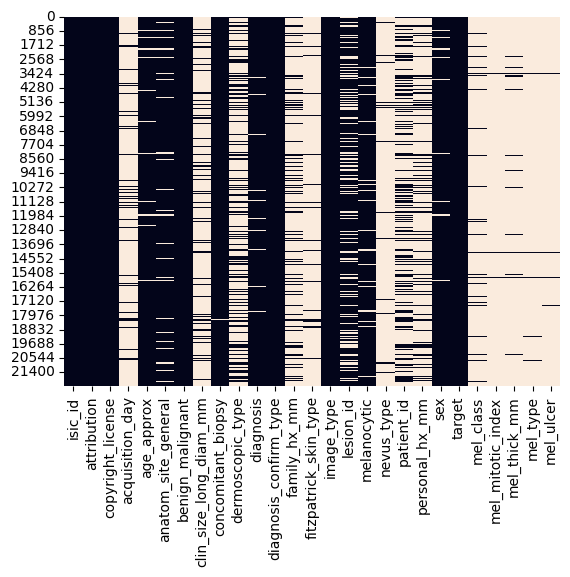

In [ ]:
sns.heatmap(data.isnull(), cbar=False)
plt.show()

In [ ]:
data['benign_malignant'].value_counts(normalize=True)

benign_malignant
benign                     0.669904
malignant                  0.329107
indeterminate/malignant    0.000989
Name: proportion, dtype: float64

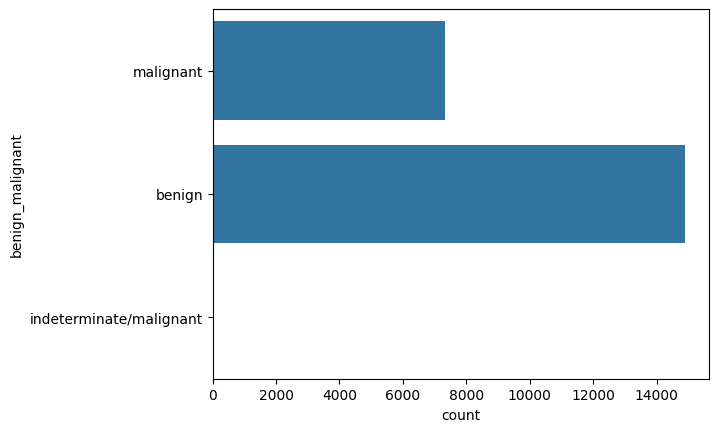

In [ ]:
sns.countplot(data['benign_malignant']);

In [ ]:
data['target'].value_counts(normalize=True)

target
0    0.669693
1    0.330307
Name: proportion, dtype: float64

In [ ]:
data['sex'].value_counts(normalize=True)

sex
male      0.518963
female    0.481037
Name: proportion, dtype: float64

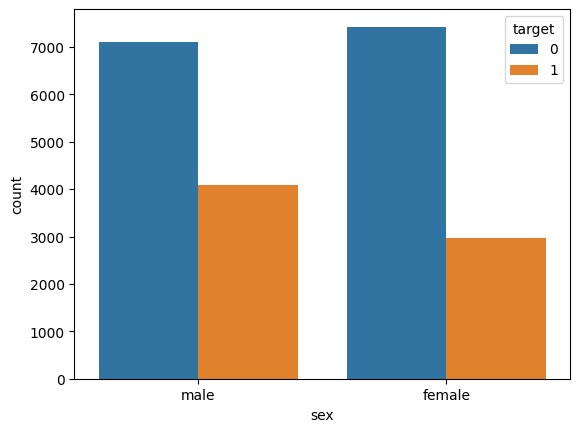

In [ ]:
sns.countplot(data=data, x='sex', hue='target');

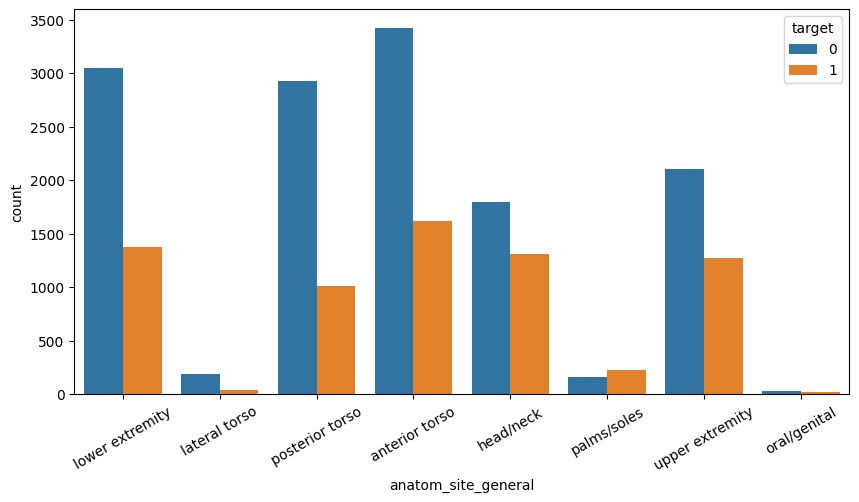

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=data, x='anatom_site_general', hue='target')
plt.xticks(rotation=30);

In [ ]:
data['diagnosis'].value_counts(normalize=True)

diagnosis
nevus                                 0.514429
melanoma                              0.337156
seborrheic keratosis                  0.037803
actinic keratosis                     0.019957
solar lentigo                         0.015598
basal cell carcinoma                  0.014589
lichenoid keratosis                   0.014085
acrochordon                           0.012249
lentigo NOS                           0.009497
verruca                               0.005276
dermatofibroma                        0.004221
angioma                               0.003120
squamous cell carcinoma               0.002386
lentigo simplex                       0.001927
other                                 0.001468
atypical melanocytic proliferation    0.001330
scar                                  0.001193
neurofibroma                          0.001193
vascular lesion                       0.000688
angiokeratoma                         0.000596
sebaceous hyperplasia                 0.000321
angiofibroma or fibrous papule        0.000184
pyogenic granuloma                    0.000138
sebaceous adenoma                     0.000092
mucosal melanosis                     0.000092
cafe-au-lait macule                   0.000092
AIMP                                  0.000092
clear cell acanthoma                  0.000092
melanoma metastasis                   0.000046
nevus spilus                          0.000046
pigmented benign keratosis            0.000046
Name: proportion, dtype: float64

In [ ]:
train_df = data[['sex','age_approx','anatom_site_general','diagnosis','target']]
train_df.head()

sex  age_approx anatom_site_general    diagnosis  target
0  male        65.0     lower extremity     melanoma       1
1  male        45.0       lateral torso     melanoma       1
2  male        80.0     posterior torso  lentigo NOS       0
3  male        55.0     lower extremity        nevus       0
4  male        75.0     posterior torso     melanoma       1

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df = train_df.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')
train_df.head()

sex  age_approx  anatom_site_general  diagnosis  target
0    1          12                    3         14       1
1    1           7                    2         14       1
2    1          15                    7         11       0
3    1          10                    3         19       0
4    1          14                    7         14       1

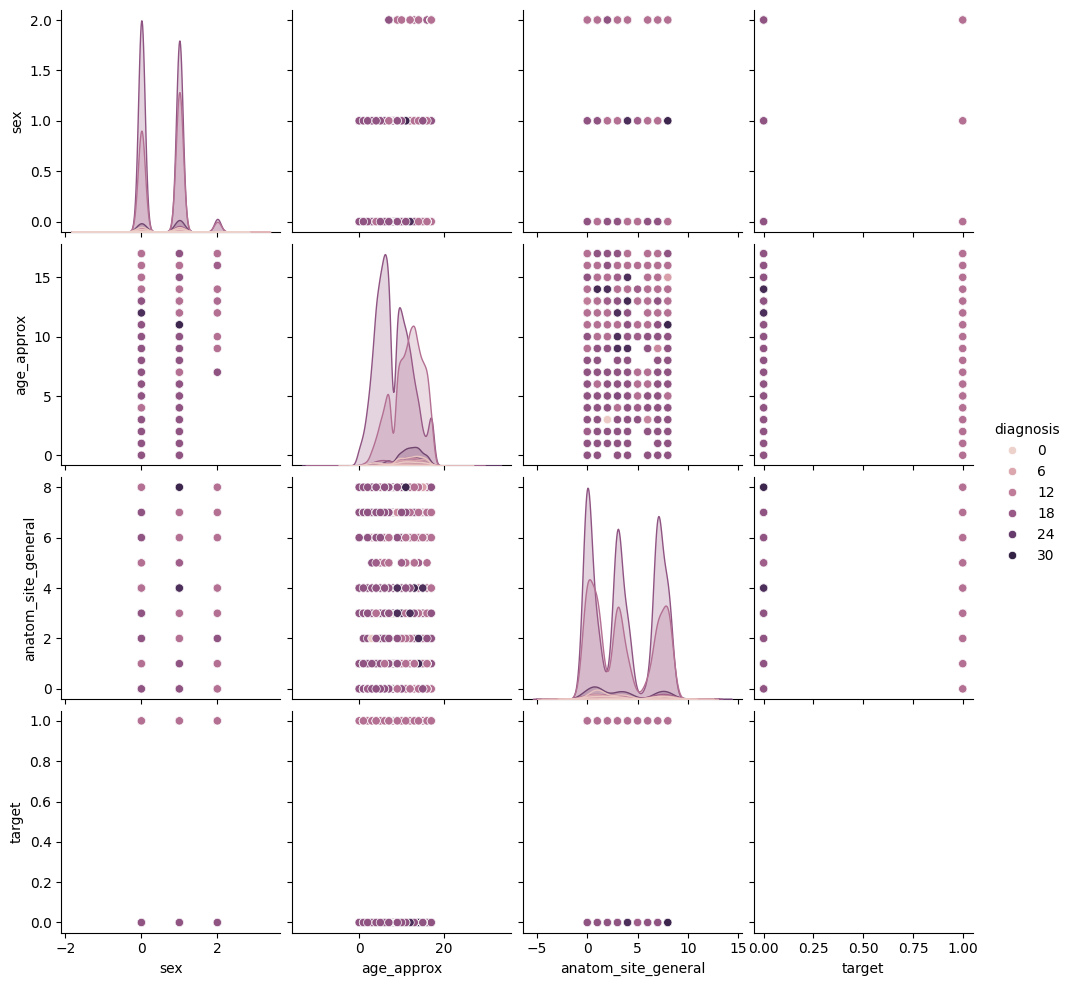

In [ ]:
g = sns.pairplot(train_df, hue="diagnosis")

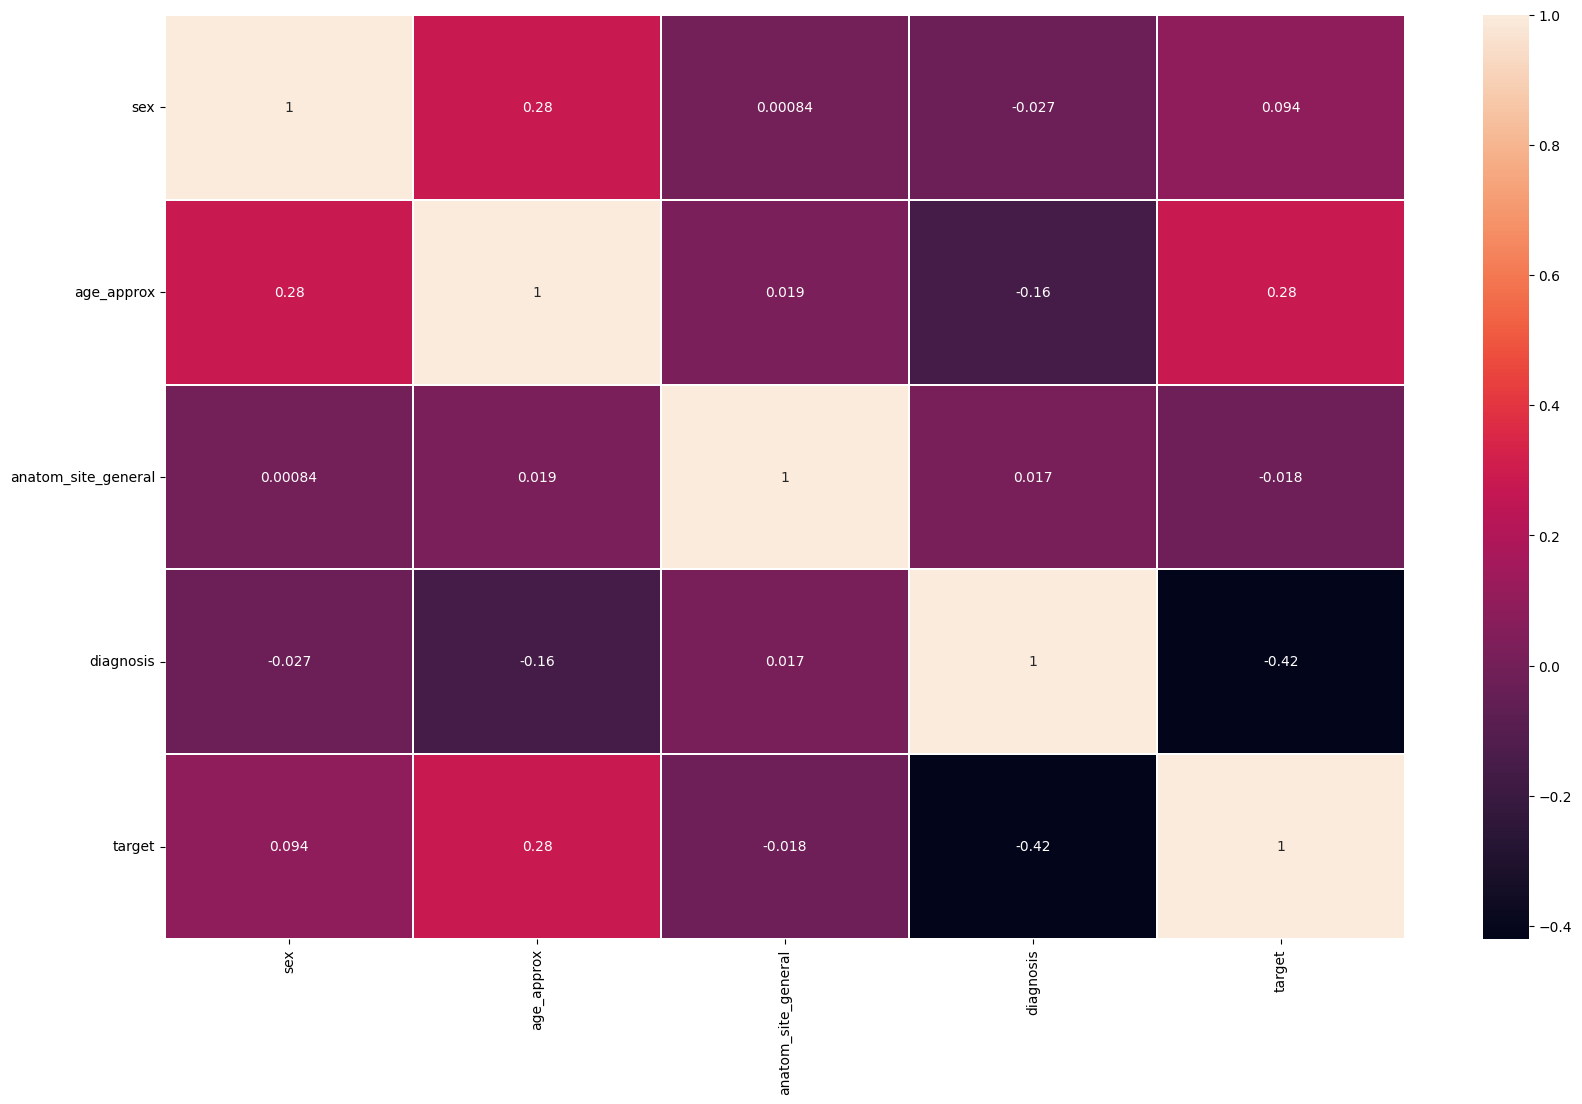

In [ ]:
sns.heatmap(train_df.corr(),annot=True,linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

### Helper Functions

In [ ]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

cols, rows = 4, 3
def grid_display(list_of_images, no_of_columns=2, figsize=(15,15), title = False):
    fig = plt.figure(figsize=figsize)
    column = 0
    z = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        if title:
            if i >= no_of_columns:
                plt.title(titles[z])
                z +=1
            else:
                plt.title(titles[i])
        plt.imshow(list_of_images[i])
        plt.axis('off')

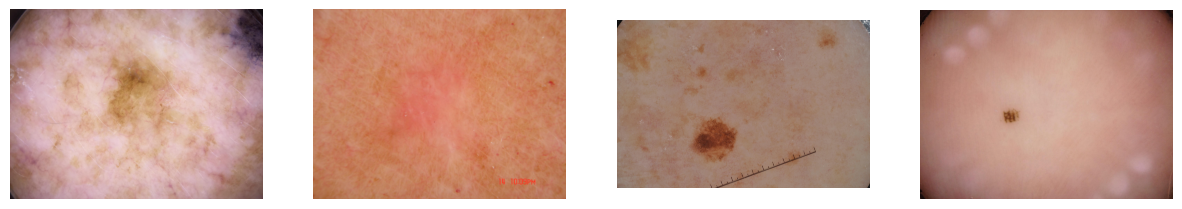

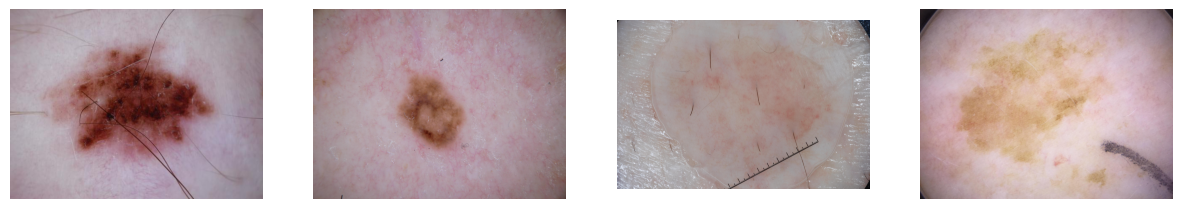

In [ ]:
image_list = data[data['target'] == 0].sample(8)['isic_id']
image_all=[]
for image_id in image_list:
    image_file = f'/content/drive/MyDrive/alalade/siim-isic-melanoma-classification/benign/'+image_id+'.jpg'
    img = np.array(Image.open(image_file))
    image_all.append(img)
#show_images(image_all, cols=1)
grid_display(image_all, 4, (15,15))

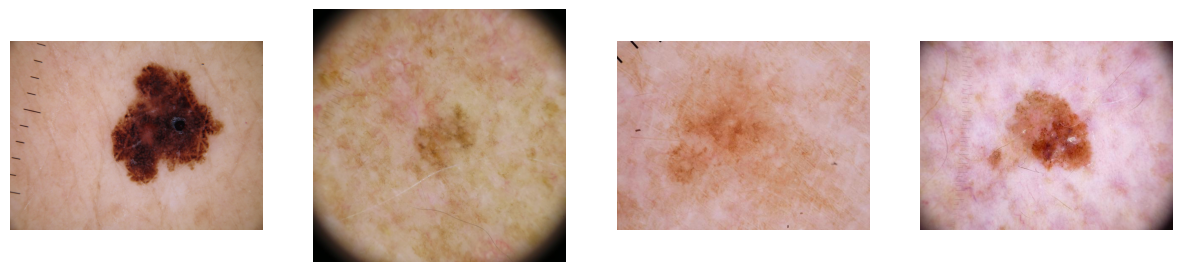

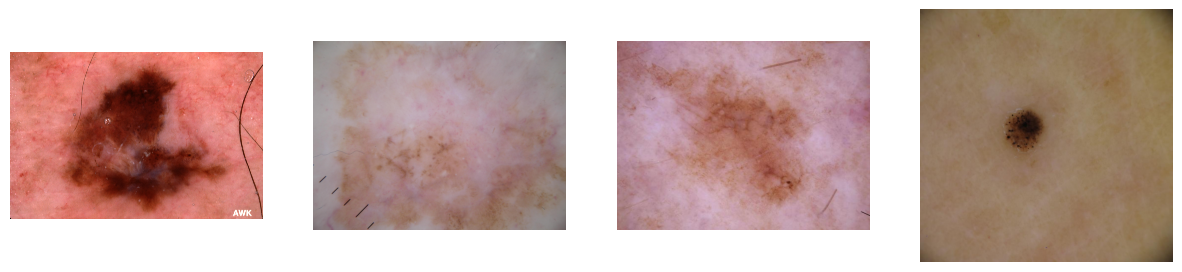

In [ ]:
image_list = data[data['target'] == 1].sample(8)['isic_id']
image_all=[]
for image_id in image_list:
    image_file = f'/content/drive/MyDrive/alalade/siim-isic-melanoma-classification/melanoma/'+image_id+'.jpg'
    img = np.array(Image.open(image_file))
    image_all.append(img)
#show_images(image_all, cols=1)
grid_display(image_all, 4, (15,15))

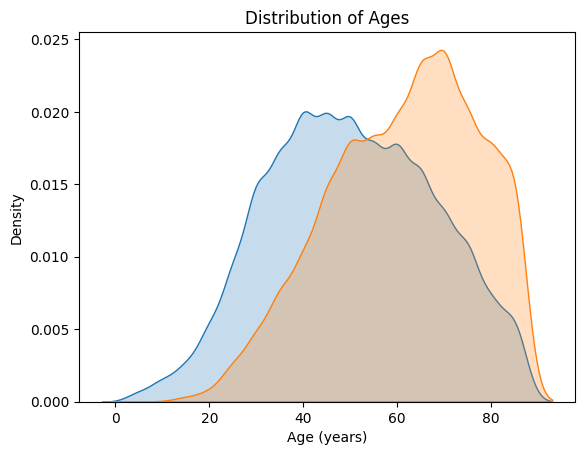

In [ ]:
# KDE plot of age that were diagnosed as benign
sns.kdeplot(data.loc[data['target'] == 0, 'age_approx'], label = 'Benign',shade=True)

# KDE plot of age that were diagnosed as malignant
sns.kdeplot(data.loc[data['target'] == 1, 'age_approx'], label = 'Malignant',shade=True)

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

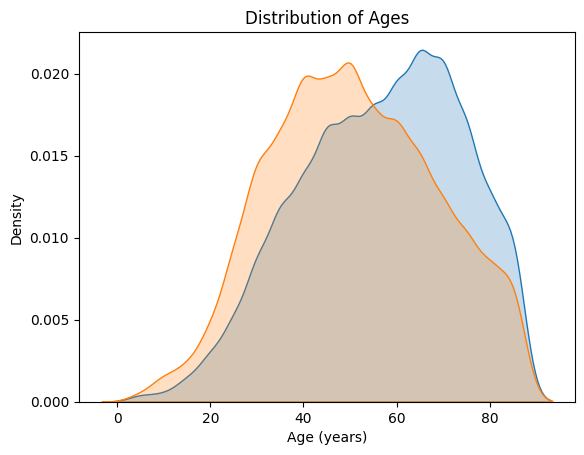

In [ ]:
# KDE plot of age that were diagnosed as benign
sns.kdeplot(data.loc[data['sex'] == 'male', 'age_approx'], label = 'Male',shade=True)

# KDE plot of age that were diagnosed as malignant
sns.kdeplot(data.loc[data['sex'] == 'female', 'age_approx'], label = 'Female',shade=True)

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

Text(44.73113194444444, 0.5, 'count of melanoma cases')

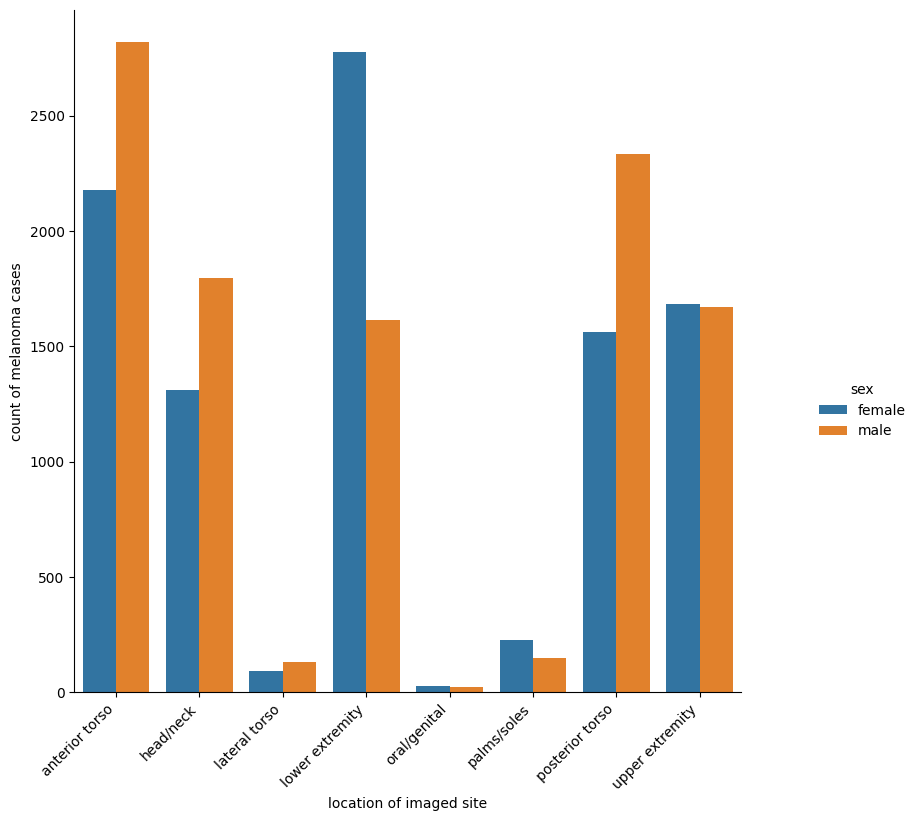

In [ ]:
z1=data.groupby(['sex','anatom_site_general'])['benign_malignant'].count().to_frame().reset_index()
z1.style.background_gradient(cmap='Reds')
sns.catplot(x='anatom_site_general',y='benign_malignant', hue='sex',data=z1,kind='bar')
plt.gcf().set_size_inches(10,8)
plt.xlabel('location of imaged site')
plt.xticks(rotation=45,fontsize='10', horizontalalignment='right')
plt.ylabel('count of melanoma cases')

## Data PreProcessing

In [ ]:
benign = data[data['benign_malignant']=='benign']
malignant = data[data['benign_malignant']=='malignant']

In [ ]:
mal_dir = '/content/drive/MyDrive/alalade/siim-isic-melanoma-classification/melanoma/'
ben_dir = '/content/drive/MyDrive/alalade/siim-isic-melanoma-classification/benign/'

Image dimensions:  (1024, 1024)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 78.5 ; Standard deviation : 58.8


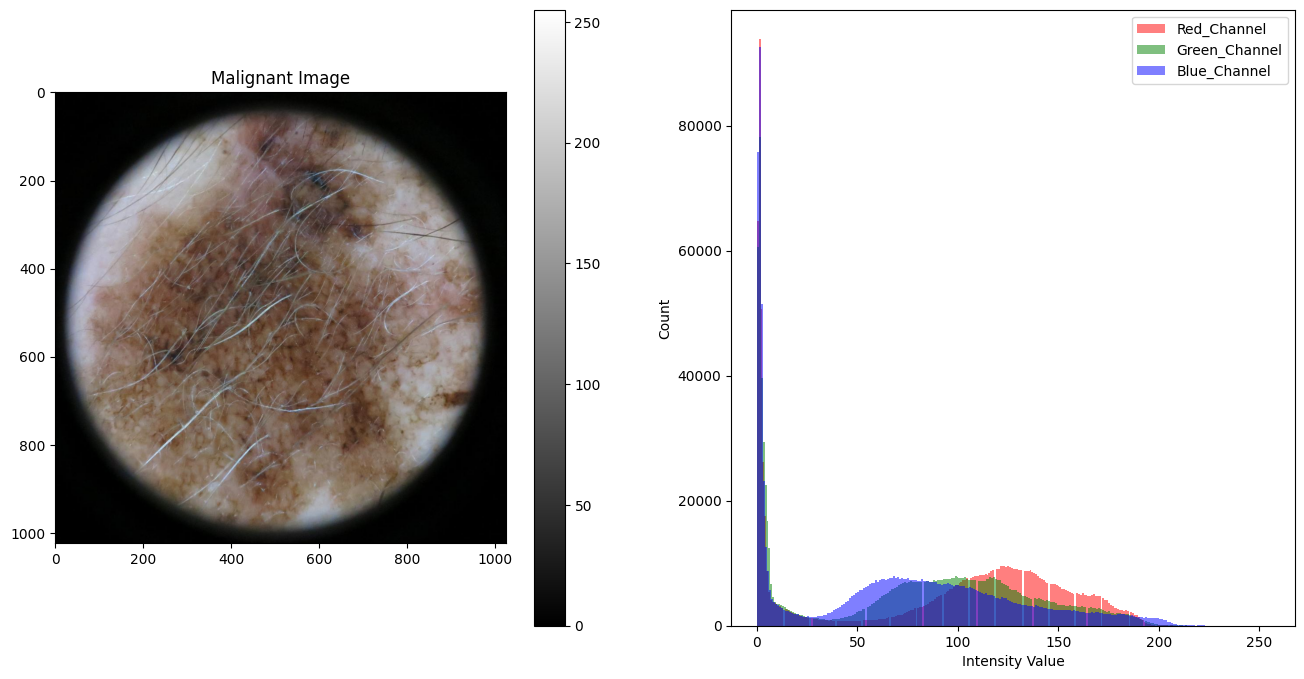

In [ ]:
f = plt.figure(figsize=(16,8))
f.add_subplot(1,2, 1)

sample_img = malignant['isic_id'][31]+'.jpg'
raw_image = plt.imread(os.path.join(mal_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Malignant Image')
print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

f.add_subplot(1,2, 2)

#_ = plt.hist(raw_image.ravel(),bins = 256, color = 'orange',)
_ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

Image dimensions:  (4381, 6622)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 183.6 ; Standard deviation : 51.7


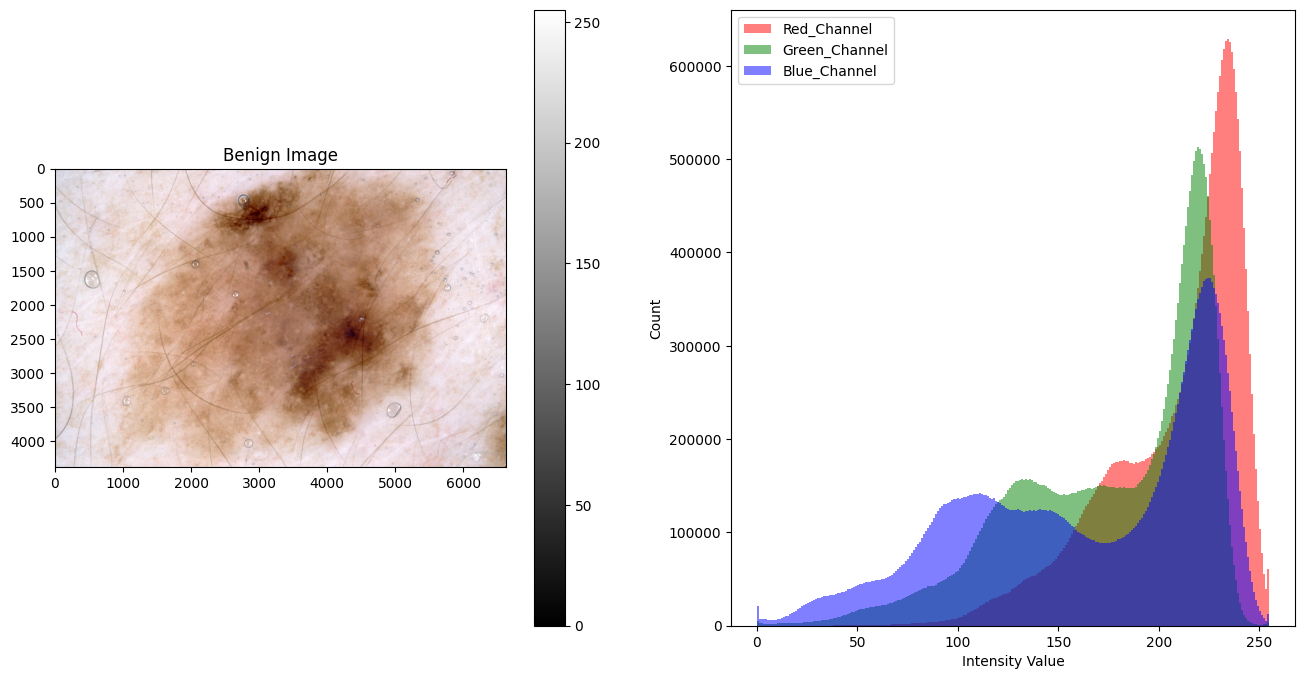

In [ ]:
f = plt.figure(figsize=(16,8))
f.add_subplot(1,2, 1)

sample_img = benign['isic_id'][30]+'.jpg'
raw_image = plt.imread(os.path.join(ben_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Benign Image')
print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

f.add_subplot(1,2, 2)

#_ = plt.hist(raw_image.ravel(),bins = 256, color = 'orange',)
_ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

## Image Processing

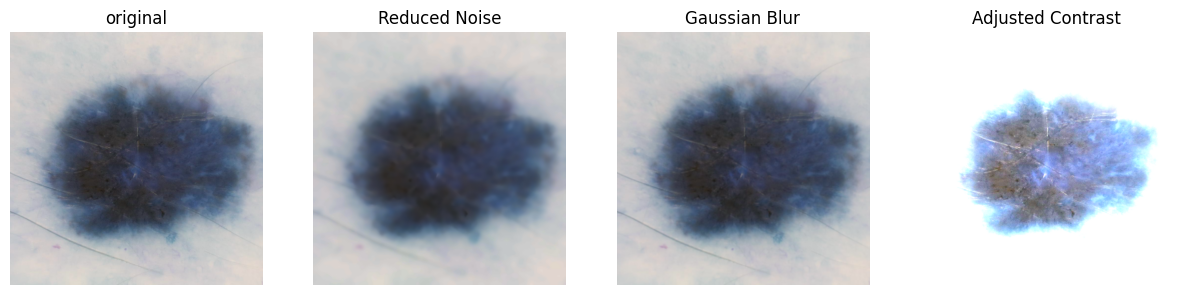

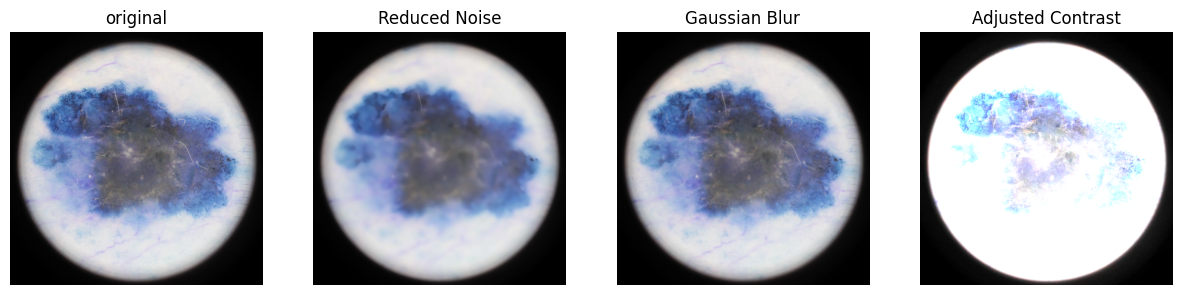

In [ ]:
image_list = data[data['target'] == 1].sample(2)['isic_id']
image_all=[]
titles = ['original', 'Reduced Noise', "Gaussian Blur", 'Adjusted Contrast']
for image_id in image_list:
    image_file = mal_dir+image_id+'.jpg'
    img = cv2.imread(image_file,1)
    image_all.append(img)
    #Reducing Noise
    result = cv2.fastNlMeansDenoisingColored(img,None,20,10,7,21)
    image_all.append(result)
    #Gaussian Blur
    blur_image = cv2.GaussianBlur(img, (7,7), 0)
    image_all.append(blur_image)
    #Adjusted contrast
    contrast_img = cv2.addWeighted(img, 2.5, np.zeros(img.shape, img.dtype), 0, 0)
    image_all.append(contrast_img)
grid_display(image_all, 4, (15,15), title = True)

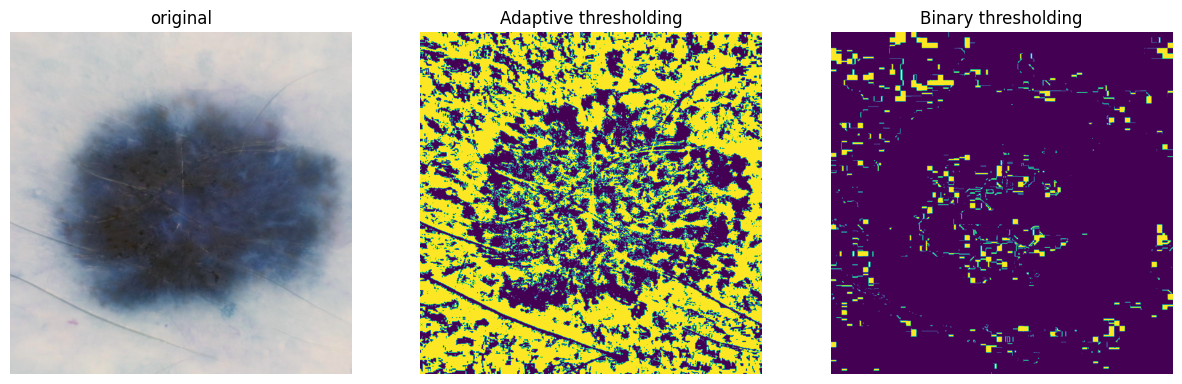

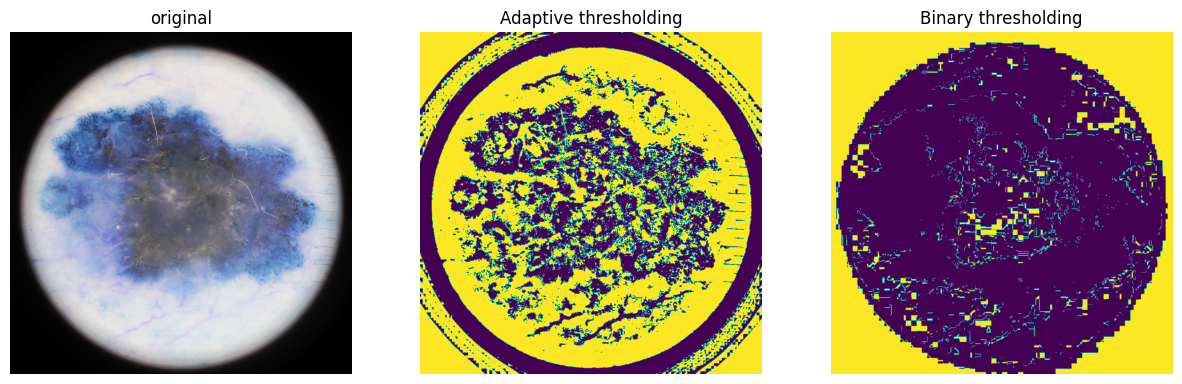

In [ ]:
titles = ['original', 'Adaptive thresholding', "Binary thresholding"]
image_all = []
for image_id in image_list:
    image_file = mal_dir+image_id+'.jpg'
    img = cv2.imread(image_file,1)
    image_all.append(img)
    #Adaptive Thresholding..
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh1 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    image_all.append(thresh1)
    #Binary Thresholding...
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    res, thresh = cv2.threshold(hsv[:, :, 0], 0, 255, cv2.THRESH_BINARY_INV)
    image_all.append(thresh)
grid_display(image_all, 3, (15,15), title = True)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import LinearSegmentedColormap

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model

In [ ]:
# Define the path where our dataset is stored
dataset_path = '/content/drive/MyDrive/alalade/siim-isic-melanoma-classification'

# Retrieve the names of all folders (representing cancer types) within the directory
cancer_types = os.listdir(dataset_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each classification type to process images
for cancer_type in cancer_types:
    folder_path = os.path.join(dataset_path, cancer_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{cancer_type} folder contains {num_images} images.")

        # # Loop over each image to check its dimensions
        # for image_file in image_files:
        #     image_path = os.path.join(folder_path, image_file)
        #     with Image.open(image_path) as img:
        #         # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
        #         width, height = img.size
        #         channels = len(img.getbands())
        #         all_dimensions_set.add((width, height, channels))

# # Determine if all images in the entore dataset have the same dimensions
# if len(all_dimensions_set) == 1:
#     width, height, channel = all_dimensions_set.pop()
#     print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
# else:
#     print("\nThe images in the dataset have different dimensions or color channels.")

melanoma folder contains 7354 images.
benign folder contains 14900 images.


In [ ]:
# Initialize an empty list to store image file paths and their respective labels
data = []
cancer_types = ['melanoma', 'benign']
# Loop through each garbage type and collect its images' file paths
for cancer_type in cancer_types:
    for file in os.listdir(os.path.join(dataset_path, cancer_type)):
        # Append the image file path and its type (as a label) to the data list
        data.append((os.path.join(dataset_path, cancer_type, file), cancer_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

filepath     label
0  /content/drive/MyDrive/alalade/siim-isic-melan...  melanoma
1  /content/drive/MyDrive/alalade/siim-isic-melan...  melanoma
2  /content/drive/MyDrive/alalade/siim-isic-melan...  melanoma
3  /content/drive/MyDrive/alalade/siim-isic-melan...  melanoma
4  /content/drive/MyDrive/alalade/siim-isic-melan...  melanoma

In [ ]:
# Split with stratification
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Number of images in the training set: 17808
Number of images in the validation set: 4453


## Data Augmentation And Rescaling

In [ ]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Using flow_from_dataframe to generate batches
# Generate training batches from the training dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 17801 validated image filenames belonging to 2 classes.
Found 4453 validated image filenames belonging to 2 classes.


In [ ]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 557
Number of batches in val_generator: 140


In [ ]:
# Extract class labels from the 'label' column of train_df
class_labels = train_df['label'].unique()
class_labels

array(['benign', 'melanoma'], dtype=object)

In [ ]:
train_generator.class_indices

{'benign': 0, 'melanoma': 1}

In [ ]:
# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])
weights

array([0.74679191, 1.51299915])

In [ ]:
# Convert the computed weights to a dictionary for passing to model training
class_weights = dict(zip(train_generator.class_indices.values(), weights))
class_weights

{0: 0.746791914786547, 1: 1.512999150382328}

## ResNet50 Residual Block

In [ ]:
def residual_block(X, kernel_size, filters, reduce=False, stride=2):
    """
    Implement a residual block for ResNet architectures.

    Arguments:
    X           -- input tensor of shape (m, height, width, channels)
    kernel_size -- integer, kernel size of the middle convolutional layer in the main path
    filters     -- python list of integers, defining the number of filters in the CONV layers of the main path
    reduce      -- boolean, whether to reduce the spatial dimensions and increase depth;
                    if True, applies 1x1 CONV layer to the shortcut path.
    stride      -- integer, strides for the convolutional layer

    Returns:
    X           -- output of the identity block, tensor of shape (height, width, channels)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We will need this later to add back to the main path.
    X_shortcut = X

    if reduce:
        # if we are to reduce the spatial size, apply a 1x1 CONV layer to the shortcut path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (stride,stride), padding = 'valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)

        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (stride,stride), padding = 'valid', kernel_initializer='he_normal')(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    else:
        # First component of main path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (kernel_size, kernel_size), strides = (1,1), padding = 'same', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis = 3)(X)

    # Final step: Add shortcut value to main path, and pass it through a ReLU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet_50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Block 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Block 2
    X = residual_block(X, 3, [64, 64, 256], reduce=True, stride=1)
    X = residual_block(X, 3, [64, 64, 256])
    X = residual_block(X, 3, [64, 64, 256])

    # Block 3
    X = residual_block(X, 3, [128, 128, 512], reduce=True, stride=2)
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])

    # Block 4
    X = residual_block(X, 3, [256, 256, 1024], reduce=True, stride=2)
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])

    # Block 5
    X = residual_block(X, 3, [512, 512, 2048], reduce=True, stride=2)
    X = residual_block(X, 3, [512, 512, 2048])
    X = residual_block(X, 3, [512, 512, 2048])

    # Global Average Pooling to reduce spatial dimensions
    X = GlobalAveragePooling2D()(X)

    # Fully Connected Layer for classification
    X = Dense(classes, activation='softmax')(X)

    # Create the model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
def Modified_ResNet50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = residual_block(X, 3, [64, 64, 256], reduce=True, stride=1)
    X = residual_block(X, 3, [64, 64, 256])
    X = residual_block(X, 3, [64, 64, 256])

    # Stage 3
    X = residual_block(X, 3, [128, 128, 512], reduce=True, stride=2)
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])

    # Stage 4
    X = residual_block(X, 3, [256, 256, 1024], reduce=True, stride=2)
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = residual_block(X, 3, [512, 512, 2048], reduce=True, stride=2)
    X = residual_block(X, 3, [512, 512, 2048])
    X = residual_block(X, 3, [512, 512, 2048])

    # Global Average Pooling to reduce spatial dimensions
    X = GlobalAveragePooling2D()(X)

    # Add Dropout to prevent overfitting
    X = Dropout(0.5)(X)

    # Fully Connected Layer for classification
    X = Dense(classes, activation='softmax')(X)

    # Create the model
    model = Model(inputs = X_input, outputs = X, name='Modified_ResNet50')

    return model

In [ ]:
# Define the shape of the input images and number of classes
input_shape = (384, 384, 3)
num_classes = 2

# Initialize the modified ResNet50 model with the specified parameters
modified_resnet50_model = Modified_ResNet50(input_shape=input_shape, classes=num_classes)

In [ ]:
# !pip install pydot

# !apt-get install graphviz

In [ ]:
# plot_model(modified_resnet50_model, show_shapes=True, show_layer_names=False, dpi=120)

In [ ]:
modified_resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Add ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=0.00001)

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True, verbose=1)

In [ ]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 557
Number of batches in val_generator: 140


In [ ]:
print("Assigned Class Weights:")
class_weights

Assigned Class Weights:


{0: 0.746791914786547, 1: 1.512999150382328}

In [ ]:
# Total number of epochs
num_epochs = 100

# Train the model
history = modified_resnet50_model.fit(train_generator,
                                      steps_per_epoch=55,
                                      epochs=num_epochs,
                                      validation_data=val_generator,
                                      validation_steps=15,
                                      class_weight=class_weights,
                                      callbacks=[reduce_lr, early_stopping])

KeyboardInterrupt: 

In [ ]:
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """

    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Plot the curves from the specified epoch onwards
    df = df.iloc[start_epoch-1:]

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

In [ ]:
plot_learning_curves(history)

NameError: name 'history' is not defined

In [ ]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """

    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
evaluate_model_performance(modified_resnet50_model, val_generator, class_labels)

In [ ]:
# Load the ResNet50 model with weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 384, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 384, 384, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 390, 390, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 192, 192, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 192, 192, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 192, 192, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 194, 194, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 96, 96, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 96, 96, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 96, 96, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 96, 96, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 96, 96, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 96, 96, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 96, 96, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 96, 96, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 96, 96, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
len(base_model.layers)

175

In [ ]:
for i, layer in enumerate(base_model.layers):
    if 140 <= i <= 150:
        print(i, layer.name)

140 conv4_block6_3_bn
141 conv4_block6_add
142 conv4_block6_out
143 conv5_block1_1_conv
144 conv5_block1_1_bn
145 conv5_block1_1_relu
146 conv5_block1_2_conv
147 conv5_block1_2_bn
148 conv5_block1_2_relu
149 conv5_block1_0_conv
150 conv5_block1_3_conv


In [ ]:
# Freeze the layers up to conv4_block6_out
for layer in base_model.layers[:143]: # include the layer 142
    layer.trainable = False

In [ ]:
# Create the new model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

transfer_resnet50_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
transfer_resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# plot_model(transfer_resnet50_model, show_shapes=True, show_layer_names=False, dpi=120)

In [ ]:
transfer_resnet50_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 384, 384, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 390, 390, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 192, 192, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 192, 192, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 192, 192, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 194, 194, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 96, 96, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 96, 96, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 96, 96, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 96, 96, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 96, 96, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 96, 96, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 96, 96, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 96, 96, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 96, 96, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 14,980,098 (57.14 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [ ]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rotation_range=60,                  # Randomly rotate the images by up to 60 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.20,                    # Randomly zoom in or out by up to 20%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest',                 # Fill in missing pixels using the nearest filled value
    preprocessing_function=preprocess_input  # Add this line
)

# For the validation set, you might not have augmentation:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # Add this line

In [ ]:
# Using flow_from_dataframe to generate batches
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 17801 validated image filenames belonging to 2 classes.
Found 4453 validated image filenames belonging to 2 classes.


## Fine-tuning the Transfer Learning ResNet50 Model¶

In [ ]:
# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)

# Total number of epochs
num_epochs = 10

# Train the model
history = transfer_resnet50_model.fit(train_generator,
                                      steps_per_epoch=55,
                                      epochs=num_epochs,
                                      validation_data=val_generator,
                                      validation_steps=15,
                                      class_weight=class_weights,
                                      callbacks=[reduce_lr, early_stopping])

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1931s 33s/step - accuracy: 0.6559 - loss: 0.7133 - val_accuracy: 0.7417 - val_loss: 0.7753 - learning_rate: 1.0000e-04
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1819s 33s/step - accuracy: 0.7113 - loss: 0.6818 - val_accuracy: 0.7958 - val_loss: 0.4438 - learning_rate: 1.0000e-04
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1819s 33s/step - accuracy: 0.6769 - loss: 0.6789 - val_accuracy: 0.7250 - val_loss: 0.5454 - learning_rate: 1.0000e-04
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1825s 33s/step - accuracy: 0.7107 - loss: 0.5861 - val_accuracy: 0.7563 - val_loss: 0.5057 - learning_rate: 1.0000e-04
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1814s 33s/step - accuracy: 0.7058 - loss: 0.6263 - val_accuracy: 0.7771 - val_loss: 0.4943 - learning_rate: 1.0000e-04
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1810s 33s/step - accuracy: 0.7337 - loss: 0.5599 - val_accuracy: 0.7750 - val_loss: 0.4666 - learning_rate: 1.0000e-04
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accura

## Evaluating the Transfer Learning ResNet50 Model¶

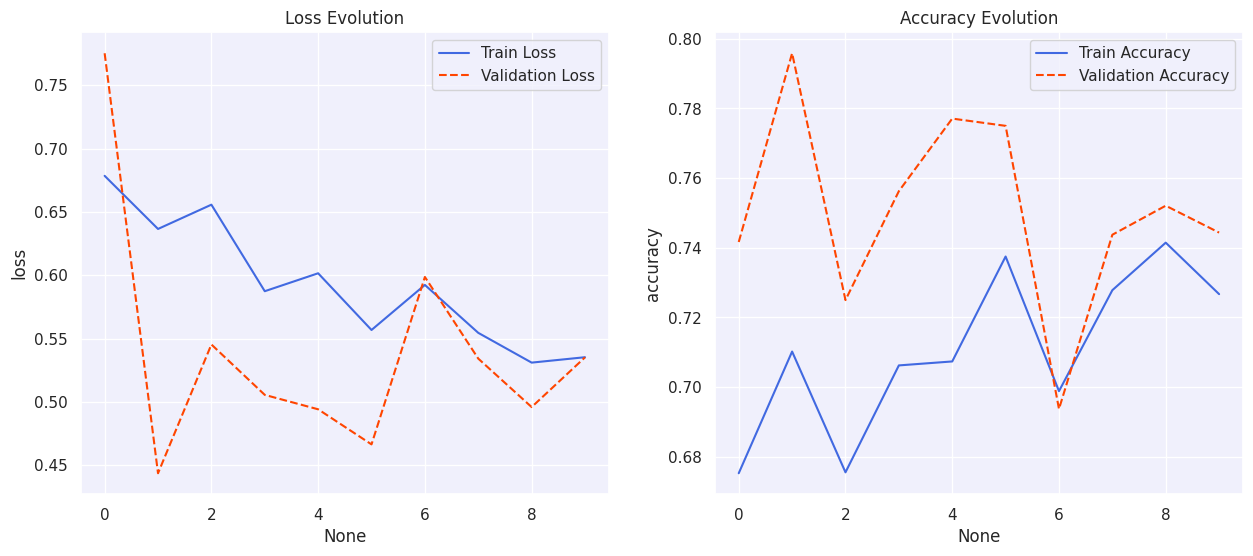

In [ ]:
plot_learning_curves(history, start_epoch=1)

###  Performance Metrics Assessment¶

140/140 ━━━━━━━━━━━━━━━━━━━━ 2544s 18s/step
              precision    recall  f1-score   support

      benign       0.79      0.86      0.82      2981
    melanoma       0.65      0.53      0.59      1472

    accuracy                           0.75      4453
   macro avg       0.72      0.70      0.70      4453
weighted avg       0.74      0.75      0.74      4453





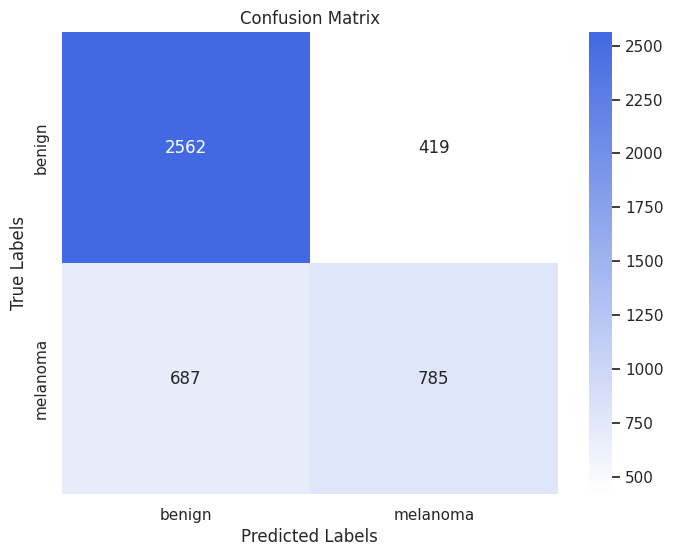

In [ ]:
evaluate_model_performance(transfer_resnet50_model, val_generator, class_labels)

### Pre-trained Model

In [3]:
## BigTransfer (BiT) family

import tensorflow as tf
import tensorflow_hub as hub
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url, trainable=True)

In [5]:
data_dir = "/content/drive/MyDrive/alalade/siim-isic-melanoma-classification"

batch_size = 32
img_size = (224, 224)

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    class_names=['benign', 'melanoma']
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    class_names=['benign', 'melanoma']
)

Found 22254 files belonging to 2 classes.
Using 17804 files for training.
Found 22254 files belonging to 2 classes.
Using 4450 files for validation.


In [6]:
num_classes = 2

model = tf.keras.Sequential([
    hub.KerasLayer(bit_model_url, trainable=True),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
557/557 [==============================] - 1624s 3s/step - loss: 0.7468 - accuracy: 0.6768 - val_loss: 0.5567 - val_accuracy: 0.7171
Epoch 2/10
557/557 [==============================] - 1572s 3s/step - loss: 0.5585 - accuracy: 0.7349 - val_loss: 0.7084 - val_accuracy: 0.7151
Epoch 3/10
557/557 [==============================] - 1566s 3s/step - loss: 0.5770 - accuracy: 0.7090 - val_loss: 0.5443 - val_accuracy: 0.7272
Epoch 4/10
557/557 [==============================] - 1579s 3s/step - loss: 0.5320 - accuracy: 0.7459 - val_loss: 0.5315 - val_accuracy: 0.7467
Epoch 5/10
557/557 [==============================] - 1570s 3s/step - loss: 0.5262 - accuracy: 0.7504 - val_loss: 0.5348 - val_accuracy: 0.7483
Epoch 6/10
557/557 [==============================] - 1572s 3s/step - loss: 0.5181 - accuracy: 0.7563 - val_loss: 0.5228 - val_accuracy: 0.7481
Epoch 7/10
557/557 [==============================] - 1580s 3s/step - loss: 0.5113 - accuracy: 0.7585 - val_loss: 0.5269 - val_accuracy:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()